In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path

import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.transform import resize

In [3]:
from tensorflow.keras import layers
from tensorflow.keras import models

In [4]:
BASE_PATH = Path("..")
sys.path.append(str(BASE_PATH.resolve()))

In [5]:
from mobilenetv1.mobilenetv1 import MobileNetV1
from mobilenetv2.mobilenetv2 import MobileNetV2

In [6]:
tf.__version__

'2.5.0'

## CIFAR-10 Dataset

In [7]:
CLASS_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [8]:
cifar10 = tf.keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [9]:
print(train_images.shape, train_labels.shape)

(50000, 32, 32, 3) (50000, 1)


In [10]:
# train_images = np.expand_dims(train_images, axis = 3)
# test_images = np.expand_dims(test_images, axis = 3)

# train_images = resize(train_images, (len(train_images),224,224,1))
# test_images = resize(test_images, (len(test_images),224,224,1))

train_labels_onehot = tf.keras.utils.to_categorical(train_labels, num_classes=len(CLASS_NAMES))
test_labels_onehot = tf.keras.utils.to_categorical(test_labels, num_classes=len(CLASS_NAMES))

In [11]:
train_images.shape

(50000, 32, 32, 3)

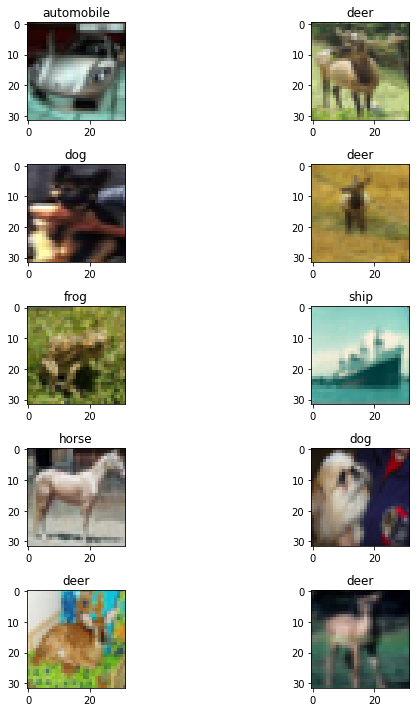

In [12]:
SAMPLE_SIZE = 10
samples = np.random.randint(0, len(train_images), size = SAMPLE_SIZE)

fig, axarr = plt.subplots(5, SAMPLE_SIZE//5, figsize = (10,10))
axs = axarr.ravel()

for idx, sample in enumerate(samples):
    axs[idx].imshow(train_images[sample,:,:,:])
    axs[idx].set_title(CLASS_NAMES[train_labels[sample,0]])
    
plt.tight_layout()

## Train Models

In [13]:
# Mobilenet V1
mobilenetv1 = MobileNetV1(train_images.shape[1:], len(CLASS_NAMES), alpha=1.0)
model_mbnet1 = mobilenetv1()

# Mobilenet V2
mobilenetv2 = MobileNetV2(train_images.shape[1:], len(CLASS_NAMES), alpha=1.0)
model_mbnet2 = mobilenetv2()

2021-09-12 23:36:44.569578: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
model_dict = {
    'MobileNetV1': model_mbnet1,
    'MobileNetV2': model_mbnet2
}

In [15]:
def train_loop(model, model_name, x_train, y_train):
    print("*" * 20)
    print(f'Training {model_name}')
    opt = tf.keras.optimizers.Adam(learning_rate=0.0003)
    model.compile(optimizer=opt,
              loss=['categorical_crossentropy'],
              metrics=['accuracy'])
    
    model.fit(
        x = x_train,
        y = y_train,
        validation_split=0.20,
        verbose=1,
        epochs = 10)
    
    return model
    

In [16]:
model_dict_trained = {k: train_loop(x, k, train_images, train_labels_onehot) for k, x in model_dict.items()}


********************
Training MobileNetV1


2021-09-12 23:36:47.166554: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
1250/1250 [==============================] - 273s 216ms/step - loss: 2.0596 - accuracy: 0.2244 - val_loss: 1.8143 - val_accuracy: 0.3225
Epoch 2/10
1250/1250 [==============================] - 299s 239ms/step - loss: 1.7189 - accuracy: 0.3599 - val_loss: 1.6104 - val_accuracy: 0.3965
Epoch 3/10
1250/1250 [==============================] - 282s 225ms/step - loss: 1.5668 - accuracy: 0.4240 - val_loss: 1.5377 - val_accuracy: 0.4189
Epoch 4/10
1250/1250 [==============================] - 275s 220ms/step - loss: 1.4597 - accuracy: 0.4681 - val_loss: 1.5357 - val_accuracy: 0.4505
Epoch 5/10
1250/1250 [==============================] - 286s 229ms/step - loss: 1.3709 - accuracy: 0.5075 - val_loss: 1.4044 - val_accuracy: 0.4977
Epoch 6/10
1250/1250 [==============================] - 282s 225ms/step - loss: 1.2844 - accuracy: 0.5374 - val_loss: 1.3538 - val_accuracy: 0.5205
Epoch 7/10
1250/1250 [==============================] - 269s 215ms/step - loss: 1.2010 - accuracy: 0.5720 - val_

## Evaluate Models

In [17]:
def evaluate_loop(model, model_name, x_test, y_test):
    print("*" * 20)
    print(f'Evaluating {model_name}')
    
    test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

    print('Test accuracy:', test_acc)

In [18]:
for k, x in model_dict_trained.items():
    evaluate_loop(x, k, test_images, test_labels_onehot)


********************
Evaluating MobileNetV1
313/313 - 7s - loss: 1.2034 - accuracy: 0.5888
Test accuracy: 0.5888000130653381
********************
Evaluating MobileNetV2
313/313 - 9s - loss: 1.0691 - accuracy: 0.6234
Test accuracy: 0.6233999729156494
